<a href="https://colab.research.google.com/github/Praveen3ravi/PROJECT/blob/main/Project_Chennai_house_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Chennai House Price Prediction**

##Problem Statement
Real estate transactions are quite opaque sometimes and it may be difficult for a newbie to know the fair price of any given home. Thus, multiple real estate websites have the functionality to predict the prices of houses given different features regarding it. Such forecasting models will help buyers to identify a fair price for the home and also give insights to sellers as to how to build homes that fetch them more money. Chennai house sale price data is shared here and the participants are expected to build a sale price prediction model that will aid the customers to find a fair price for their homes and also help the sellers understand what factors are fetching more money for the houses?

Data : 'https://raw.githubusercontent.com/Praveen3ravi/PROJECT/main/train-chennai-sale.csv'

Minimum Requirements
It is not sufficient to just fit a model - the model must be analysed to find the important factors that contribute towards the price. Also, it will be better to give a forecast range (range of permissible values) rather than a single estimate as it will help the customers to negotiate.




In [1074]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_style('dark')
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

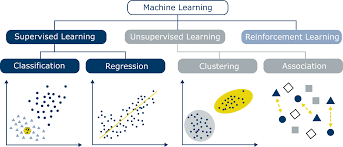






In [1075]:
url='https://raw.githubusercontent.com/Praveen3ravi/PROJECT/main/train-chennai-sale.csv'
df = pd.read_csv(url)
print(df.columns)
print('The total number of features:',df.shape[1])

Index(['PRT_ID', 'AREA', 'INT_SQFT', 'DATE_SALE', 'DIST_MAINROAD', 'N_BEDROOM',
       'N_BATHROOM', 'N_ROOM', 'SALE_COND', 'PARK_FACIL', 'DATE_BUILD',
       'BUILDTYPE', 'UTILITY_AVAIL', 'STREET', 'MZZONE', 'QS_ROOMS',
       'QS_BATHROOM', 'QS_BEDROOM', 'QS_OVERALL', 'REG_FEE', 'COMMIS',
       'SALES_PRICE'],
      dtype='object')
The total number of features: 22


In [1076]:
df.head(2)

,PRT_ID,AREA,INT_SQFT,DATE_SALE,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,DATE_BUILD,BUILDTYPE,UTILITY_AVAIL,STREET,MZZONE,QS_ROOMS,QS_BATHROOM,QS_BEDROOM,QS_OVERALL,REG_FEE,COMMIS,SALES_PRICE
0,P03210,Karapakkam,1004,04-05-2011,131,1.0,1.0,3,AbNormal,Yes,15-05-1967,Commercial,AllPub,Paved,A,4.0,3.9,4.9,4.330,380000,144400,7600000
1,P09411,Anna Nagar,1986,19-12-2006,26,2.0,1.0,5,AbNormal,No,22-12-1995,Commercial,AllPub,Gravel,RH,4.9,4.2,2.5,3.765,760122,304049,21717770


#**Supervised Regression Problem.**
   We have the "*target variable(df["SALES_PRICE"])*" and the type of *Target variable is continuous*. Since we are trying to predict a continuous value, it is called Regression problem

# **FEATURE ENGINEERING / DATA CLEANING**

In [1077]:
print("Total number of features in the data is:",df.shape[1])
pd.DataFrame(df.dtypes.value_counts()).T

Total number of features in the data is: 22


,object,float64,int64
0,10,6,6


In [1078]:
categorical_features = [x for x in df.columns 
                if not (df[x].dtype == np.float64 
                        or df[x].dtype == np.int64)]
print(categorical_features)

['PRT_ID', 'AREA', 'DATE_SALE', 'SALE_COND', 'PARK_FACIL', 'DATE_BUILD', 'BUILDTYPE', 'UTILITY_AVAIL', 'STREET', 'MZZONE']


In [1079]:
numerical_features=[x for x in df.columns if df[x].dtype==np.int64 or df[x].dtype==np.float64]
print(numerical_features)

['INT_SQFT', 'DIST_MAINROAD', 'N_BEDROOM', 'N_BATHROOM', 'N_ROOM', 'QS_ROOMS', 'QS_BATHROOM', 'QS_BEDROOM', 'QS_OVERALL', 'REG_FEE', 'COMMIS', 'SALES_PRICE']


In [1080]:
print('The data has {} categorical features'.format(len(categorical_features)))
print('The data has {} numerical_features'.format(len(numerical_features)))

The data has 10 categorical features
The data has 12 numerical_features


In [1081]:
pd.DataFrame(df.isnull().sum()).T

,PRT_ID,AREA,INT_SQFT,DATE_SALE,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,DATE_BUILD,BUILDTYPE,UTILITY_AVAIL,STREET,MZZONE,QS_ROOMS,QS_BATHROOM,QS_BEDROOM,QS_OVERALL,REG_FEE,COMMIS,SALES_PRICE
0,0,0,0,0,0,1,5,0,0,0,0,0,0,0,0,0,0,0,48,0,0,0


### **INTERPRETATION**

In [1082]:
# df['N_BEDROOM'].value_counts()         #1_BHK=3796; 2_BHK=2352; 3_BHK=707; 4_BHK=254;
# df['N_BATHROOM'].value_counts()      # 1_BATHROOM is 5594; 2_BATHROOM is 1515
# df['AREA'].value_counts()            #1.chrompet, 2.karapakam, 3.KK, 4.Velacherry, 5.Anna Nagar, 6.Adyar, 7.T Nagar.
# df['QS_OVERALL'].value_counts() 
# df['SALE_COND'].value_counts()       #Equal.
# df['PARK_FACIL'].value_counts()      # Equal.
# df['UTILITY_AVAIL'].value_counts()   #NoSewer = 3700; AllPub = 1887; ELO = 1522;
# df['STREET'].value_counts()          # More equally same.
# df['AREA'].unique()
# df['SALE_COND'].unique()
# df['BUILDTYPE'].unique()
# df['UTILITY_AVAIL'].unique()
# df['STREET'].unique()
# df['PARK_FACIL'].unique()
# df['N_BEDROOM'].unique()
# df['N_BATHROOM'].unique()
# df['N_ROOM'].unique()
# df[['N_BEDROOM','SALE_COND']].groupby('SALE_COND').count()

###**FILLING THE NULL VALUES**

In [1083]:
df['N_BEDROOM']=df['N_BEDROOM'].fillna(df['N_BEDROOM'].mean())
df['N_BATHROOM']=df['N_BATHROOM'].fillna(df['N_BATHROOM'].mean())
df['QS_OVERALL']=df['QS_OVERALL'].fillna(df['QS_OVERALL'].mean())

df['N_BEDROOM'] = np.floor(df['N_BEDROOM'])
df['N_BATHROOM'] = np.floor(df['N_BATHROOM'])

###**SPELLING CORRECTIONS**

In [1084]:
df['PARK_FACIL'].replace(['Noo'],['No'],inplace=True)
df['STREET'].replace(['Pavd','NoAccess'],['Paved','No Access'],inplace=True)
df['UTILITY_AVAIL'].replace(['NoSewr ','NoSeWa','All Pub'],['No Sewer','No Sewer','AllPub'],inplace=True)
df['BUILDTYPE'].replace(['Comercial','Other'],['Commercial','Others'],inplace=True)
df['SALE_COND'].replace(['Ab Normal','Partiall','PartiaLl','Adj Land'],['AbNormal','Partial','Partial','AdjLand'],inplace=True)
df['AREA'].replace(['Ana Nagar','Ann Nagar','Karapakam','Chrompt','Chrmpet','Chormpet','Adyr','Velchery','KKNagar','TNagar'],
['Anna Nagar','Anna Nagar','Karapakkam','Chrompet','Chrompet','Chrompet','Adyar','Velachery','KK Nagar','T Nagar'],
inplace=True)

In [1085]:
# pd.DataFrame(df.isnull().sum()).T
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7109 entries, 0 to 7108
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PRT_ID         7109 non-null   object 
 1   AREA           7109 non-null   object 
 2   INT_SQFT       7109 non-null   int64  
 3   DATE_SALE      7109 non-null   object 
 4   DIST_MAINROAD  7109 non-null   int64  
 5   N_BEDROOM      7109 non-null   float64
 6   N_BATHROOM     7109 non-null   float64
 7   N_ROOM         7109 non-null   int64  
 8   SALE_COND      7109 non-null   object 
 9   PARK_FACIL     7109 non-null   object 
 10  DATE_BUILD     7109 non-null   object 
 11  BUILDTYPE      7109 non-null   object 
 12  UTILITY_AVAIL  7109 non-null   object 
 13  STREET         7109 non-null   object 
 14  MZZONE         7109 non-null   object 
 15  QS_ROOMS       7109 non-null   float64
 16  QS_BATHROOM    7109 non-null   float64
 17  QS_BEDROOM     7109 non-null   float64
 18  QS_OVERA

###**CREATING NEW FEATURES FOR DATE_SALE & DATE_BUILD.**

In [1086]:
df['DATE_SALE']=pd.to_datetime(df['DATE_SALE'])
df['DATE_BUILD']=pd.to_datetime(df['DATE_BUILD'])
pd.DataFrame(df.dtypes.value_counts()).T

,object,float64,int64,datetime64[ns]
0,8,6,6,2


In [1087]:
df['BUILD_YEAR'] = df['DATE_BUILD'].dt.year
# df['BUILD_MONTH'] = df['DATE_BUILD'].dt.month
# df['BUILD_DAY'] = df['DATE_BUILD'].dt.day
df['SALE_YEAR'] = df['DATE_SALE'].dt.year
# df['SALE_MONTH'] = df['DATE_SALE'].dt.month
# df['SALE_DAY'] = df['DATE_SALE'].dt.day

In [1088]:
df["SOLD_AGE"]=df['SALE_YEAR']-df['BUILD_YEAR']

### **DROPPING THE FEATURES WHICH MAKE NO SENSE.**

*Droping ['DATE_SALE','DATE_BUILD'] because we have retrieved the years from those both the features. Droping['PRT_ID'] because we dont need this feature for modeling. Droping ['QS_ROOMS','QS_OVERALL','QS_BATHROOM','MZZONE','QS_BEDROOM'] because they are proprietary(masked) features. Last but not the least, they have less relation with the target variable.*

In [1089]:
df.drop(['DATE_SALE','DATE_BUILD','MZZONE','PRT_ID','QS_ROOMS','QS_OVERALL','QS_BATHROOM','QS_BEDROOM'],axis=1,inplace=True)

### **TRANSFORMING THE FEATURES TO CHECK IF THERE IS AN INCREASE IN LINEAR RELATION WITH TARGET VARIABLE.**



In [1090]:
# df['QS_ROOMS']=np.log(df['QS_ROOMS'])
# df['QS_OVERALL']=np.log(df['QS_OVERALL'])
# df['QS_BATHROOM']=np.log(df['QS_BATHROOM'])
# df['QS_BEDROOM']=np.log(df['QS_BEDROOM'])

###**CORRELATION MATRIX**

,INT_SQFT,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,REG_FEE,COMMIS,SALES_PRICE,BUILD_YEAR,SALE_YEAR,SOLD_AGE
SALES_PRICE,0.612125,0.018783,0.330987,0.108834,0.60276,0.878148,0.626275,1.0,0.116043,0.000906,-0.118842


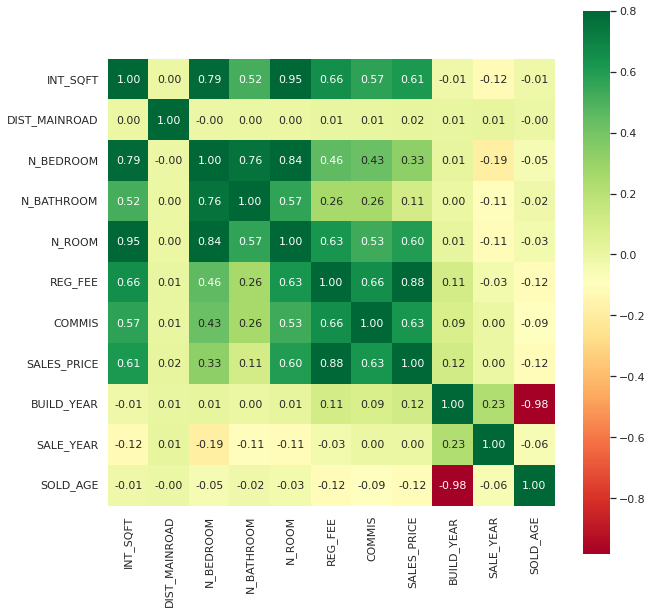

In [1091]:
#correlation matrix
corrmat = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corrmat, cbar=True, fmt='.2f', annot=True, cmap='RdYlGn', annot_kws={'size':11},vmax=.8, square=True);
pd.DataFrame(df[df.columns[:]].corr()['SALES_PRICE'][:]).T

###**APPLIED INFLATION TO 4% FOR MY TARGET VARIABLE.**

**What is Inflation** : 'https://en.wikipedia.org/wiki/Inflation'

In [1092]:
url2 = 'https://raw.githubusercontent.com/Praveen3ravi/PROJECT/main/INF%20-%20train-chennai-sale.csv'
df_=pd.read_csv(url2)
df=pd.concat([df,df_['INF_PRICE']],axis=1)
df.head()

,AREA,INT_SQFT,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,SALE_COND,PARK_FACIL,BUILDTYPE,UTILITY_AVAIL,STREET,REG_FEE,COMMIS,SALES_PRICE,BUILD_YEAR,SALE_YEAR,SOLD_AGE,INF_PRICE
0,Karapakkam,1004,131,1.0,1.0,3,AbNormal,Yes,Commercial,AllPub,Paved,380000,144400,7600000,1967,2011,44,33433509.12
1,Anna Nagar,1986,26,2.0,1.0,5,AbNormal,No,Commercial,AllPub,Gravel,760122,304049,21717770,1995,2006,11,22823005.24
2,Adyar,909,70,1.0,1.0,3,AbNormal,Yes,Commercial,ELO,Gravel,421094,92114,13159200,1992,2012,20,15080108.56
3,Velachery,1855,14,3.0,2.0,5,Family,No,Others,No Sewer,Paved,356321,77042,9630290,1988,2010,22,25455362.75
4,Karapakkam,1226,84,1.0,1.0,3,AbNormal,Yes,Others,AllPub,Gravel,237000,74063,7406250,1979,2009,30,24868474.05


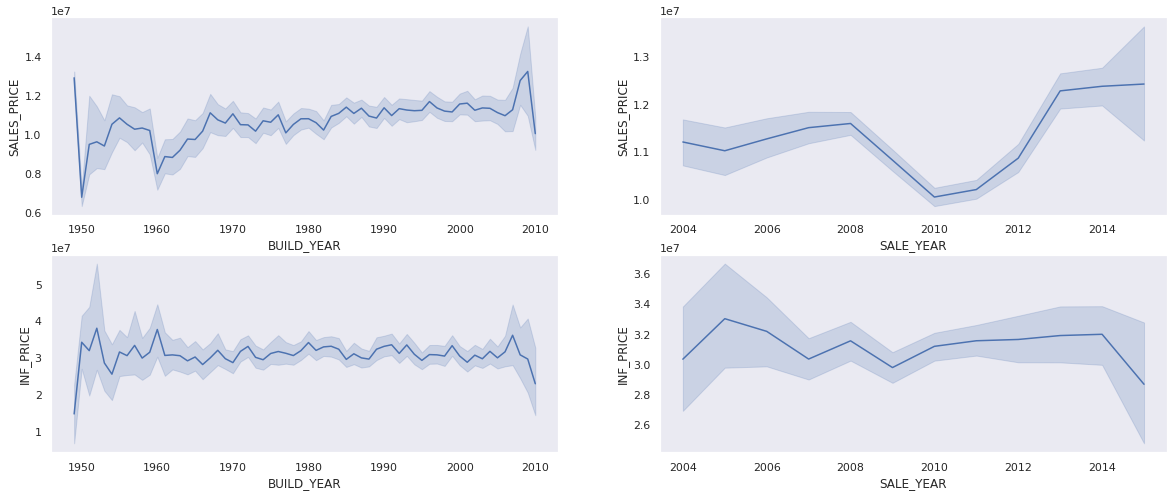

In [1093]:
plt.figure(figsize=(20,8))
plt.subplot(221)
sns.lineplot(x = "BUILD_YEAR", y = df["SALES_PRICE"], data = df)
plt.subplot(222)
sns.lineplot(x = "SALE_YEAR", y = df["SALES_PRICE"], data = df)
plt.subplot(223)
sns.lineplot(x = "BUILD_YEAR", y = df["INF_PRICE"], data = df)
plt.subplot(224)
sns.lineplot(x = "SALE_YEAR", y = df["INF_PRICE"], data = df)
plt.show()

BEFORE INFLATION AND AFTER INFLATION.


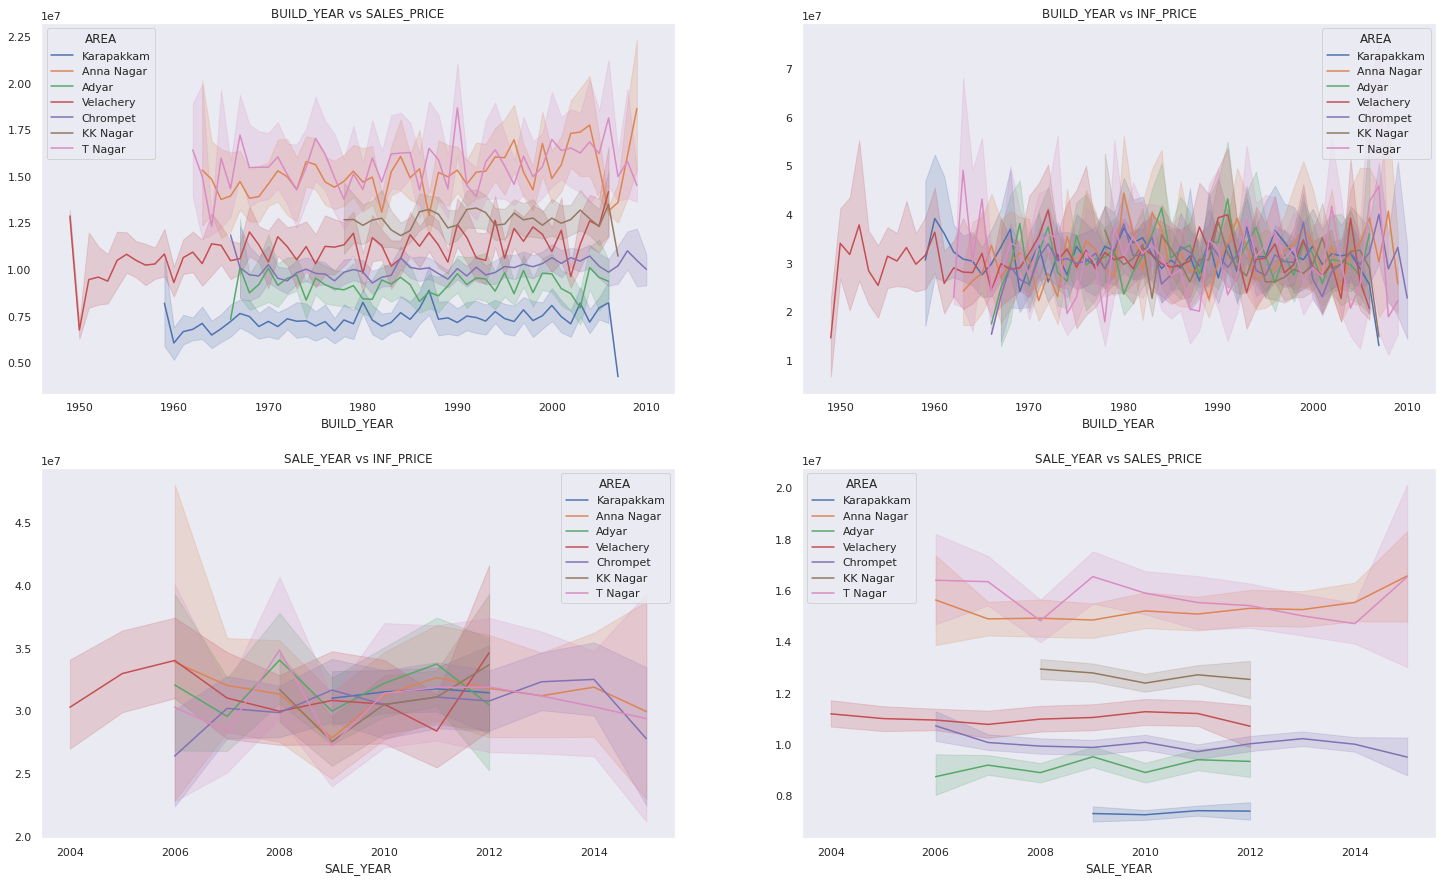

In [1094]:
# df_ = pd.DataFrame(df,columns=['BUILD_YEAR','AREA','BUILDTYPE','SOLD_AGE','SALES_PRICE','SALE_YEAR'])
plt.figure(figsize=(25,15))
print('BEFORE INFLATION AND AFTER INFLATION.')
plt.subplot(221)
sns.lineplot(x = "BUILD_YEAR", y = df["SALES_PRICE"].values, data = df,hue='AREA')
plt.title('BUILD_YEAR vs SALES_PRICE')
plt.subplot(222)
sns.lineplot(x = "BUILD_YEAR", y = df["INF_PRICE"].values, data = df,hue='AREA')
plt.title('BUILD_YEAR vs INF_PRICE')
plt.subplot(223)
sns.lineplot(x = "SALE_YEAR", y = df["INF_PRICE"].values, data = df,hue='AREA')
plt.title('SALE_YEAR vs INF_PRICE')
plt.subplot(224)
sns.lineplot(x = "SALE_YEAR", y = df["SALES_PRICE"].values, data = df,hue='AREA')
plt.title('SALE_YEAR vs SALES_PRICE')
plt.show()
# df_ = df.groupby(df['BUILD_YEAR']).count()

BEFORE INFLATION AND AFTER INFLATION.


No handles with labels found to put in legend.


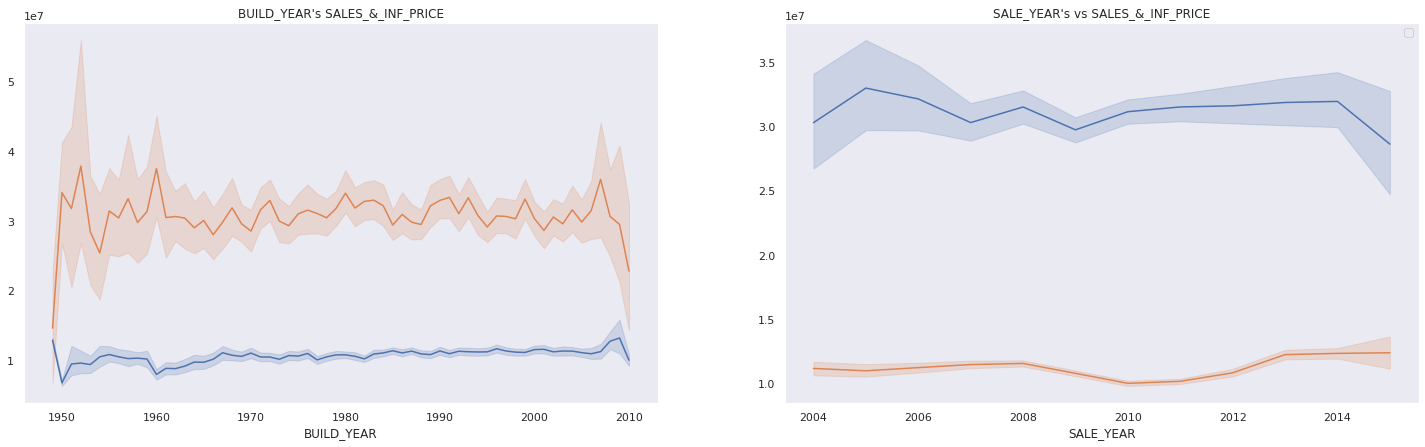

In [1095]:
plt.figure(figsize=(25,7))
print('BEFORE INFLATION AND AFTER INFLATION.')
plt.subplot(121)
sns.lineplot(x = "BUILD_YEAR", y = df["SALES_PRICE"].values, data = df)
sns.lineplot(x = "BUILD_YEAR", y = df["INF_PRICE"].values, data = df)
plt.title("BUILD_YEAR's SALES_&_INF_PRICE")
plt.subplot(122)
sns.lineplot(x = "SALE_YEAR", y = df["INF_PRICE"].values, data = df)
sns.lineplot(x = "SALE_YEAR", y = df["SALES_PRICE"].values, data = df)
plt.title("SALE_YEAR's vs SALES_&_INF_PRICE")
plt.legend()
plt.show()
# df_ = df.groupby(df['BUILD_YEAR']).count()

# **DATA VISUALISATION**

##**PLOT VISUALISATION**

In [1096]:
A=df['AREA'].groupby(df['AREA']).count()
B=df['AREA'].groupby(df['BUILDTYPE']).count()
C=df['AREA'].groupby(df['UTILITY_AVAIL']).count()
D=df['AREA'].groupby(df['STREET']).count()

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 41.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 58.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 61.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


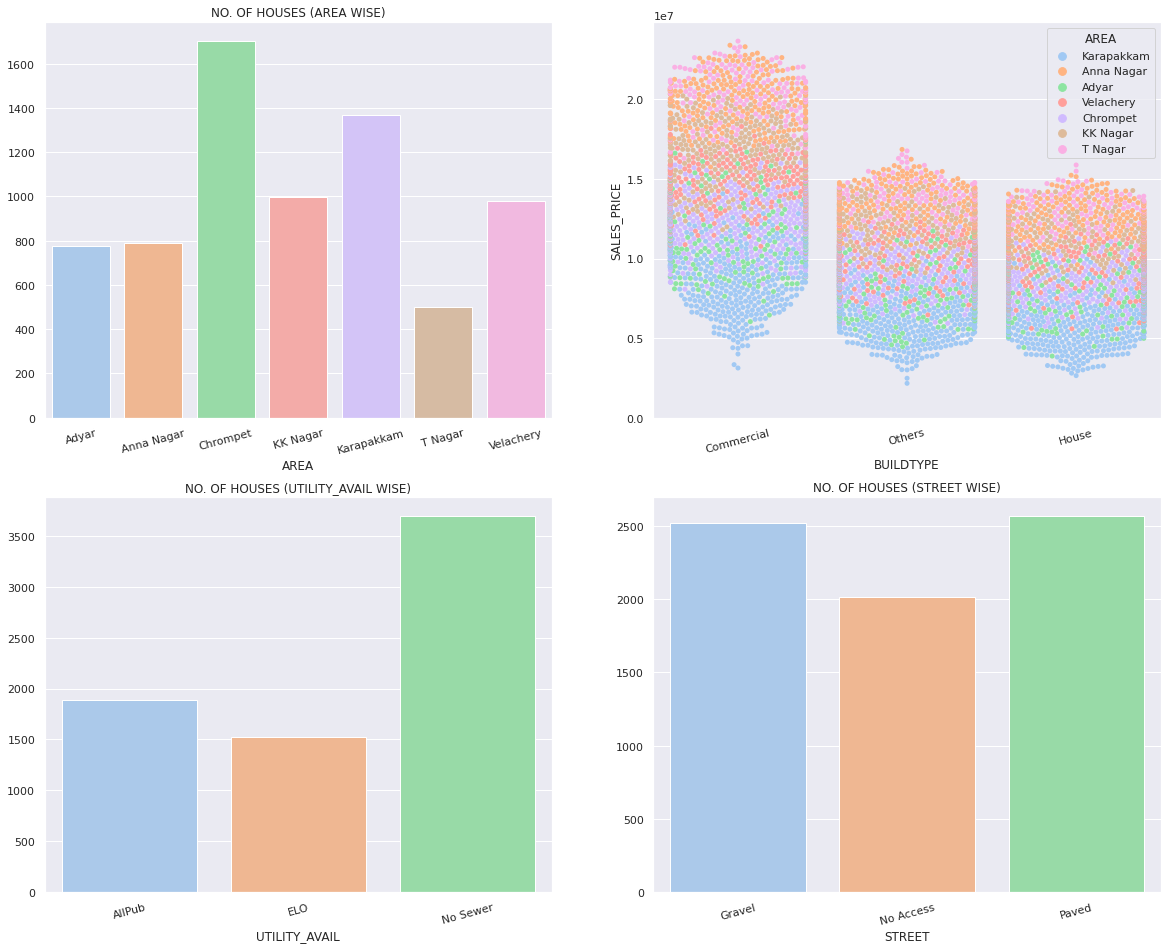

In [1097]:
sns.set_theme(style="darkgrid",palette="pastel")
plt.figure(figsize=(20,16))
plt.subplot(221)
sns.barplot(x=A.index,y=A.values,data=df)
plt.xticks(rotation=15)
plt.title('NO. OF HOUSES (AREA WISE)')
plt.subplot(222)
sns.barplot(x=B.index,y=B.values,data=df)
plt.xticks(rotation=15)
sns.swarmplot(x=df['BUILDTYPE'],y=df['SALES_PRICE'],hue=df['AREA'])
plt.subplot(223)
sns.barplot(x=C.index,y=C.values,data=df)
plt.xticks(rotation=15)
plt.title('NO. OF HOUSES (UTILITY_AVAIL WISE)')
plt.subplot(224)
sns.barplot(x=D.index,y=D.values,data=df)
plt.xticks(rotation=15)
plt.title('NO. OF HOUSES (STREET WISE)')
plt.show()

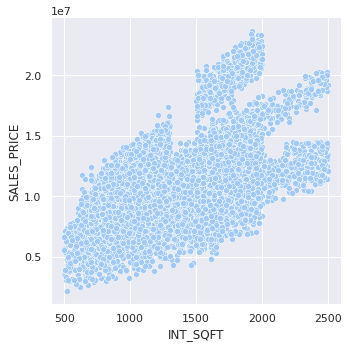

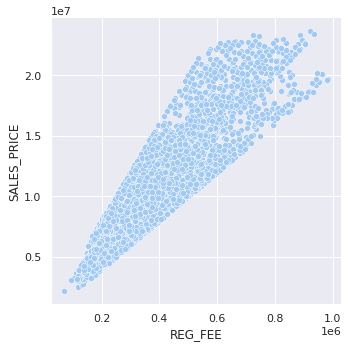

In [1098]:
# plt.subplot(121)
sns.relplot(x=df['INT_SQFT'].astype('float64'), y=df['SALES_PRICE'].astype('float64'))
# plt.subplot(122)
sns.relplot(x=df['REG_FEE'].astype('float64'), y=df['SALES_PRICE'].astype('float64'))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


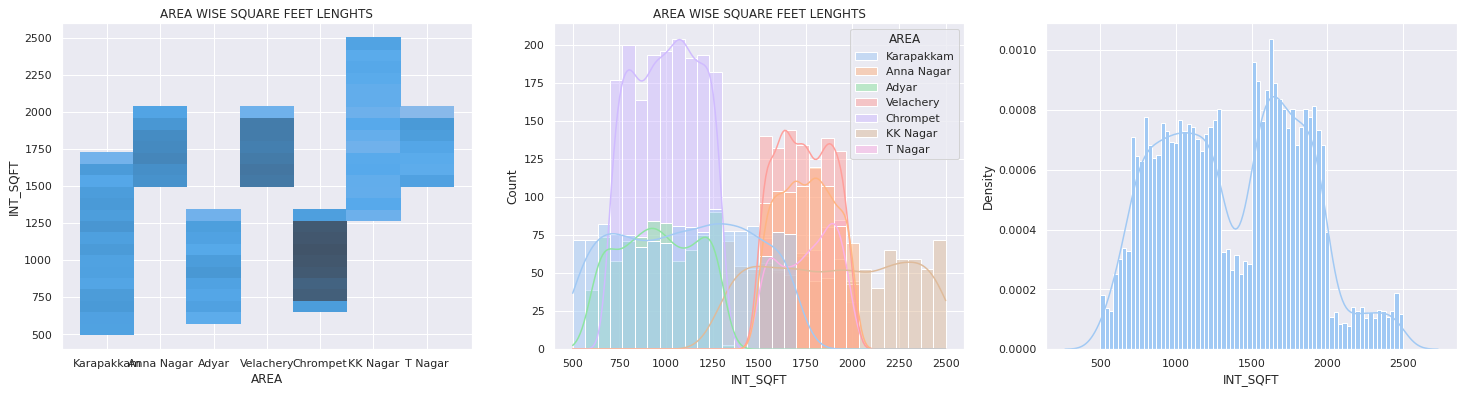

In [1099]:
plt.figure(figsize=(25,6))
plt.subplot(131)
sns.histplot(x='AREA',y='INT_SQFT',data=df)
plt.xlabel('AREA')
plt.ylabel('INT_SQFT')
plt.title('AREA WISE SQUARE FEET LENGHTS')
plt.subplot(132)
sns.histplot(df,x='INT_SQFT',bins=30,kde=True,hue="AREA")
plt.xlabel('INT_SQFT')
plt.title('AREA WISE SQUARE FEET LENGHTS')
plt.subplot(133)
sns.distplot(df['INT_SQFT'],bins=70,hist_kws={'alpha':1})
plt.show()

##**TABLE VISUALISATION**

In [1100]:
df.describe()

,INT_SQFT,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,REG_FEE,COMMIS,SALES_PRICE,BUILD_YEAR,SALE_YEAR,SOLD_AGE,INF_PRICE
count,7109.000000,7109.000000,7109.000000,7109.000000,7109.000000,7109.000000,7109.000000,7.109000e+03,7109.000000,7109.000000,7109.000000,7.109000e+03
mean,1382.073006,99.603179,1.636939,1.213110,3.688704,376938.330708,141005.726544,1.089491e+07,1985.491912,2009.768181,24.276270,3.112183e+07
std,457.410902,57.403110,0.802881,0.409534,1.019099,143070.662010,78768.093718,3.768603e+06,12.648859,2.205979,12.334164,1.874328e+07
min,500.000000,0.000000,1.000000,1.000000,2.000000,71177.000000,5055.000000,2.156875e+06,1949.000000,2004.000000,3.000000,3.949440e+06
25%,993.000000,50.000000,1.000000,1.000000,3.000000,272406.000000,84219.000000,8.272100e+06,1976.000000,2008.000000,14.000000,1.786010e+07
50%,1373.000000,99.000000,1.000000,1.000000,4.000000,349486.000000,127628.000000,1.033505e+07,1986.000000,2010.000000,23.000000,2.614715e+07
75%,1744.000000,148.000000,2.000000,1.000000,4.000000,451562.000000,184506.000000,1.299390e+07,1996.000000,2011.000000,34.000000,3.881276e+07
max,2500.000000,200.000000,4.000000,2.000000,6.000000,983922.000000,495405.000000,2.366734e+07,2010.000000,2015.000000,55.000000,1.418921e+08


In [1101]:
#----------------------------------------
#BUILDTYPE WISE MIN.AVG.MAX Sales_Prices:-
#----------------------------------------
buildtype_fltr_C = df['BUILDTYPE']=='Commercial'
commercial=df.loc[buildtype_fltr_C]
min = commercial['SALES_PRICE'].min()
mean= commercial['SALES_PRICE'].mean()
median = commercial['SALES_PRICE'].median()
max = commercial['SALES_PRICE'].max()
index=['Minimun_Sales_Price','Average_Sales_Price','Median_Sales_Price','Maximum_Sales_Price']
comm = pd.DataFrame([min,mean,median,max],columns=['Commercial'],index=index)

buildtype_fltr_H = df['BUILDTYPE']=='House'
House=df.loc[buildtype_fltr_H]
min = House['SALES_PRICE'].min()
mean= House['SALES_PRICE'].mean()
median = House['SALES_PRICE'].median()
max = House['SALES_PRICE'].max()
# index=['Minimun_Sales_Price','Average_Sales_Price','Median_Sales_Price','Maximum_Sales_Price']
house = pd.DataFrame([min,mean,median,max],columns=['House'],index=index)

buildtype_fltr_O = df['BUILDTYPE']=='Others'
Others=df.loc[buildtype_fltr_O]
min = Others['SALES_PRICE'].min()
mean= Others['SALES_PRICE'].mean()
median = Others['SALES_PRICE'].median()
max = Others['SALES_PRICE'].max()
# index=['Minimun_Sales_Price','Average_Sales_Price','Median_Sales_Price','Maximum_Sales_Price']
others = pd.DataFrame([min,mean,median,max],columns=['Others'],index=index)

In [1102]:
Build_type_mmm = pd.concat([comm,house,others],axis=1)
Build_type_mmm

,Commercial,House,Others
Minimun_Sales_Price,3.120000e+06,2.640250e+06,2.156875e+06
Average_Sales_Price,1.386984e+07,9.098847e+06,9.807998e+06
Median_Sales_Price,1.335620e+07,8.985370e+06,9.637260e+06
Maximum_Sales_Price,2.366734e+07,1.588093e+07,1.685901e+07


In [1103]:
#----------------------------
#AREA WISE MIN.AVG.MAX Sales_Prices:-
#----------------------------
mean=df.groupby('AREA')['SALES_PRICE'].mean()
mean_=mean.values
max=df.groupby('AREA')['SALES_PRICE'].max()
max_=max.values
min=df.groupby('AREA')['SALES_PRICE'].min()
min_=min.values
median=df.groupby('AREA')['SALES_PRICE'].median()
median_=min.values
Area_mmm=pd.DataFrame([min_,mean_,median_,max_],columns=mean.index,index=['MIN','MEAN','MEDIAN','MAX']).T
Area_mmm

#MERGING
# mmm2=pd.DataFrame([min_,mean_,max_],index=['MIN','MEAN','MAX'],columns=mean.index).T
# mmm=pd.concat([mmm1,mmm2],axis=0)
# mmm.T

,MIN,MEAN,MEDIAN,MAX
AREA,,,,
Adyar,3869180.0,9.185668e+06,3869180.0,17360470.0
Anna Nagar,9593040.0,1.516820e+07,9593040.0,23407860.0
Chrompet,5340900.0,1.001381e+07,5340900.0,16026600.0
KK Nagar,7410200.0,1.269623e+07,7410200.0,20246360.0
Karapakkam,2156875.0,7.340100e+06,2156875.0,14486250.0
T Nagar,9433610.0,1.561674e+07,9433610.0,23667340.0
Velachery,5574400.0,1.104735e+07,5574400.0,18298710.0


In [1104]:
pd.DataFrame(df[['AREA', 'BUILDTYPE','SALES_PRICE']].groupby(['BUILDTYPE','AREA']).count()).T

BUILDTYPE   Commercial                      ...     Others                  
AREA             Adyar Anna Nagar Chrompet  ... Karapakkam T Nagar Velachery
SALES_PRICE        247        252      562  ...        447     167       322

[1 rows x 21 columns]

# **ENCODING THE CATEGORICAL FEATURES**

In [1105]:
pd.DataFrame(df.dtypes.value_counts()).T

,int64,object,float64
0,9,6,3


In [1106]:
print("Have to Encode/Transform the listed categorical features to numeric:",categorical_features)

Have to Encode/Transform the listed categorical features to numeric: ['PRT_ID', 'AREA', 'DATE_SALE', 'SALE_COND', 'PARK_FACIL', 'DATE_BUILD', 'BUILDTYPE', 'UTILITY_AVAIL', 'STREET', 'MZZONE']


In [1107]:
Encoded = pd.get_dummies(df,columns=['AREA', 'SALE_COND',
 'PARK_FACIL',
 'BUILDTYPE',
 'UTILITY_AVAIL',
 'STREET'], drop_first=True)
print(Encoded)

      INT_SQFT  DIST_MAINROAD  ...  STREET_No Access  STREET_Paved
0         1004            131  ...                 0             1
1         1986             26  ...                 0             0
2          909             70  ...                 0             0
3         1855             14  ...                 0             1
4         1226             84  ...                 0             0
...        ...            ...  ...               ...           ...
7104       598             51  ...                 1             0
7105      1897             52  ...                 1             0
7106      1614            152  ...                 0             0
7107       787             40  ...                 0             1
7108      1896            156  ...                 0             1

[7109 rows x 29 columns]


In [1108]:
df = pd.concat([df,Encoded],axis=1)

In [1109]:
df.drop(columns=['AREA', 'SALE_COND',
 'PARK_FACIL',
 'BUILDTYPE',
 'UTILITY_AVAIL',
 'STREET'],axis=1,inplace=True)

In [1110]:
df = df.T.drop_duplicates().T

In [1111]:
df.head()

,INT_SQFT,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,N_ROOM,REG_FEE,COMMIS,SALES_PRICE,BUILD_YEAR,SALE_YEAR,SOLD_AGE,INF_PRICE,AREA_Anna Nagar,AREA_Chrompet,AREA_KK Nagar,AREA_Karapakkam,AREA_T Nagar,AREA_Velachery,SALE_COND_AdjLand,SALE_COND_Family,SALE_COND_Normal Sale,SALE_COND_Partial,PARK_FACIL_Yes,BUILDTYPE_House,BUILDTYPE_Others,UTILITY_AVAIL_ELO,UTILITY_AVAIL_No Sewer,STREET_No Access,STREET_Paved
0,1004.0,131.0,1.0,1.0,3.0,380000.0,144400.0,7600000.0,1967.0,2011.0,44.0,33433509.12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1986.0,26.0,2.0,1.0,5.0,760122.0,304049.0,21717770.0,1995.0,2006.0,11.0,22823005.24,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,909.0,70.0,1.0,1.0,3.0,421094.0,92114.0,13159200.0,1992.0,2012.0,20.0,15080108.56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1855.0,14.0,3.0,2.0,5.0,356321.0,77042.0,9630290.0,1988.0,2010.0,22.0,25455362.75,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,1226.0,84.0,1.0,1.0,3.0,237000.0,74063.0,7406250.0,1979.0,2009.0,30.0,24868474.05,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


#**FEATURE SELECTION**

##**CORRELATION WITHIN THE FEATURES**

In [1112]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from scipy.stats import pearsonr

In [1113]:
X=df.drop(['SALES_PRICE','INF_PRICE'],axis=1)
y=df['SALES_PRICE']

In [1114]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5687, 27), (1422, 27), (5687,), (1422,))

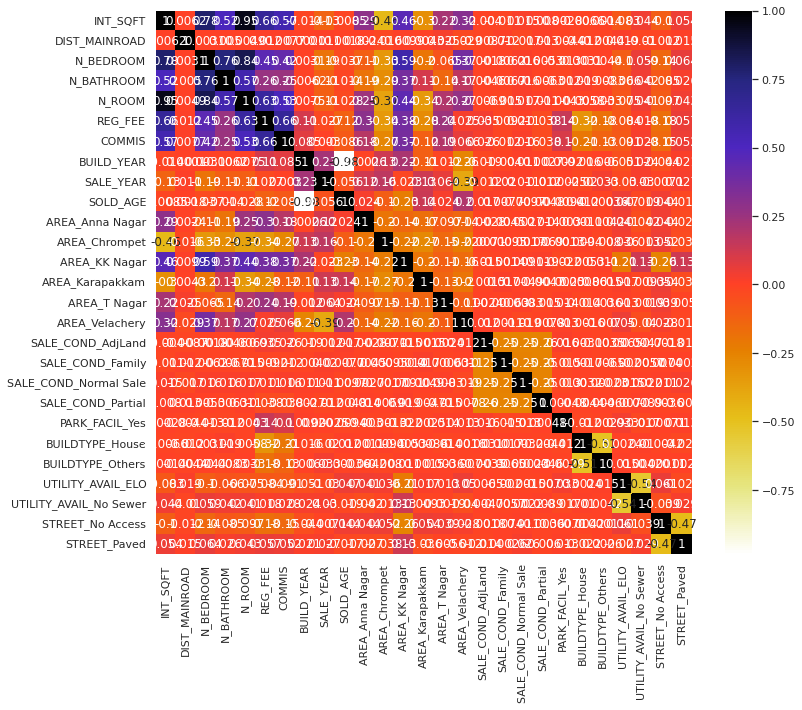

In [1115]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = X_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [1116]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold: # we are use absolute() to even focus on -ve coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [1117]:
corr_features = correlation(X_train, 0.8)
# len(set(corr_features))
print('This column are highly correlated with another column:',corr_features)

This column are highly correlated with another column: {'N_ROOM'}


In [1118]:
cwf_train=X_train.drop(corr_features,axis=1)
cwf_test=X_test.drop(corr_features,axis=1)

In [1119]:
cwf_train.shape
# y_train.shape

(5687, 26)

In [1120]:
train = pd.concat([cwf_train,y_train],axis=1)
test = pd.concat([cwf_test,y_test],axis=1)

In [1121]:
new_df=pd.concat([train,test],axis=0)
new_df.shape
print("PREVIOUSLY THE NO. OF FEATURE IS:",df.shape)
print("NOW THE NO. OF FEATURE IS:",new_df.shape)
print("{} FEATURE IS BEEN REDUCED AFTER CORRELATION WITHIN INDEPENDENT FEATURES".format(df.shape[1]-new_df.shape[1]))

PREVIOUSLY THE NO. OF FEATURE IS: (7109, 29)
NOW THE NO. OF FEATURE IS: (7109, 27)
2 FEATURE IS BEEN REDUCED AFTER CORRELATION WITHIN INDEPENDENT FEATURES


In [1122]:
new_df.head(2)

,INT_SQFT,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,REG_FEE,COMMIS,BUILD_YEAR,SALE_YEAR,SOLD_AGE,AREA_Anna Nagar,AREA_Chrompet,AREA_KK Nagar,AREA_Karapakkam,AREA_T Nagar,AREA_Velachery,SALE_COND_AdjLand,SALE_COND_Family,SALE_COND_Normal Sale,SALE_COND_Partial,PARK_FACIL_Yes,BUILDTYPE_House,BUILDTYPE_Others,UTILITY_AVAIL_ELO,UTILITY_AVAIL_No Sewer,STREET_No Access,STREET_Paved,SALES_PRICE
4469,1155.0,158.0,1.0,1.0,286394.0,133650.0,1976.0,2011.0,35.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,9546450.0
4722,1785.0,148.0,1.0,1.0,436974.0,62425.0,1970.0,2008.0,38.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,12484960.0


In [1123]:
new_df = pd.concat([new_df,df_['INF_PRICE']],axis=1)
new_df.head(2)

,INT_SQFT,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,REG_FEE,COMMIS,BUILD_YEAR,SALE_YEAR,SOLD_AGE,AREA_Anna Nagar,AREA_Chrompet,AREA_KK Nagar,AREA_Karapakkam,AREA_T Nagar,AREA_Velachery,SALE_COND_AdjLand,SALE_COND_Family,SALE_COND_Normal Sale,SALE_COND_Partial,PARK_FACIL_Yes,BUILDTYPE_House,BUILDTYPE_Others,UTILITY_AVAIL_ELO,UTILITY_AVAIL_No Sewer,STREET_No Access,STREET_Paved,SALES_PRICE,INF_PRICE
0,1004.0,131.0,1.0,1.0,380000.0,144400.0,1967.0,2011.0,44.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,7600000.0,33433509.12
1,1986.0,26.0,2.0,1.0,760122.0,304049.0,1995.0,2006.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21717770.0,22823005.24


##**CORRELATION WITH TARGET VARIABLE**

In [1124]:
#correlation matrix
corrmat = new_df.corr()
plt.figure(figsize=(40, 10))
# sns.heatmap(corrmat, cbar=True, fmt='.2f', annot=True, cmap='RdYlGn', square=True);
i=pd.DataFrame(new_df[new_df.columns[:]].corr()['SALES_PRICE'][:]).T
i=i.iloc[0]
pd.DataFrame(i).T

,INT_SQFT,DIST_MAINROAD,N_BEDROOM,N_BATHROOM,REG_FEE,COMMIS,BUILD_YEAR,SALE_YEAR,SOLD_AGE,AREA_Anna Nagar,AREA_Chrompet,AREA_KK Nagar,AREA_Karapakkam,AREA_T Nagar,AREA_Velachery,SALE_COND_AdjLand,SALE_COND_Family,SALE_COND_Normal Sale,SALE_COND_Partial,PARK_FACIL_Yes,BUILDTYPE_House,BUILDTYPE_Others,UTILITY_AVAIL_ELO,UTILITY_AVAIL_No Sewer,STREET_No Access,STREET_Paved,SALES_PRICE,INF_PRICE
SALES_PRICE,0.612125,0.018783,0.330987,0.108834,0.878148,0.626275,0.116043,0.000906,-0.118842,0.40039,-0.131183,0.193062,-0.460068,0.34502,0.016186,0.042032,-0.020856,0.013178,-0.03714,0.146428,-0.344982,-0.201783,-0.058934,0.00396,-0.149341,0.032493,1.0,-0.006097


<Figure size 2880x720 with 0 Axes>

In [1125]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from scipy.stats import pearsonr
scaler=StandardScaler()
minmax=MinMaxScaler()

In [1126]:
X=new_df.drop(['SALES_PRICE','INF_PRICE'],axis=1)
y=new_df['SALES_PRICE']

In [1127]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5687, 26), (1422, 26), (5687,), (1422,))

In [1128]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled2 = minmax.fit_transform(X_train)
X_test_scaled2 = minmax.transform(X_test)

In [1129]:
best_features_X = SelectKBest(score_func=f_regression,k=20).fit_transform(X,y)
# print(best_features_X.scores_)

In [1130]:
correlation_list=[]
for column in X.columns:
  corr_list=pearsonr(X[column],y)
  correlation_list.append([column,corr_list[0],corr_list[1]])

In [1131]:
corr_df=pd.DataFrame(correlation_list,columns=['Features','Correlation','P-Value'])
corr_df.sort_values(by='P-Value',inplace=True)
corr_df.head()

,Features,Correlation,P-Value
0,INT_SQFT,0.612125,0.000000e+00
5,COMMIS,0.626275,0.000000e+00
4,REG_FEE,0.878148,0.000000e+00
12,AREA_Karapakkam,-0.460068,0.000000e+00
9,AREA_Anna Nagar,0.400390,5.327695e-272


In [1132]:
# def correlation(dataset, threshold):
#     col_corr = set()  # Set of all the names of correlated columns
#     corr_matrix = dataset.corr()
#     for i in range(len(corr_matrix.columns)):
#         for j in range(i):
#             if abs(corr_matrix.iloc[i, j]) > threshold: # we are use absolute() to even focus on -ve coeff value
#                 colname = corr_matrix.columns[i]  # getting the name of column
#                 col_corr.add(colname)
#     return col_corr

# X=new_df.drop(['SALES_PRICE','INF_PRICE'],axis=1)
# y=new_df['SALES_PRICE']

# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=1)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

# corr_features = correlation(X_train, 0.4)
# # corr_features
# print('This column are highly(>0.4) correlated with Target variable:',corr_features)

In [1133]:
model_training_feature = corr_df['Features'].head(10)
model_training_feature = model_training_feature.to_list()
model_training_feature

['INT_SQFT',
 'COMMIS',
 'REG_FEE',
 'AREA_Karapakkam',
 'AREA_Anna Nagar',
 'AREA_T Nagar',
 'BUILDTYPE_House',
 'N_BEDROOM',
 'BUILDTYPE_Others',
 'AREA_KK Nagar']

In [1134]:
new_df = pd.DataFrame(new_df,columns=model_training_feature)
new_df=pd.concat([new_df,df['SALES_PRICE']],axis=1)

In [1135]:
new_df.head(2)

,INT_SQFT,COMMIS,REG_FEE,AREA_Karapakkam,AREA_Anna Nagar,AREA_T Nagar,BUILDTYPE_House,N_BEDROOM,BUILDTYPE_Others,AREA_KK Nagar,SALES_PRICE
0,1004.0,144400.0,380000.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,7600000.0
1,1986.0,304049.0,760122.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,21717770.0


##**VARIANCE INFLATION FACTOR**

*Variance inflation factor (VIF) is a measure of the amount of multicollinearity in a set of multiple regression variables. Mathematically, the VIF for a regression model variable is equal to the ratio of the overall model variance to the variance of a model that includes only that single independent variable.*

In [1136]:
X=new_df.drop(['SALES_PRICE'],axis=1)
y=new_df['SALES_PRICE']

In [1137]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5687, 10), (1422, 10), (5687,), (1422,))

In [1138]:
#if VIF is more than 4 then we have change the feature. 
from sklearn.linear_model import LinearRegression
lr_model=LinearRegression()
lr_model.fit(X_train,y_train)
r2=lr_model.score(X_train,y_train)
vif=1/(1-r2)
vif

11.938170028866073

# **DATA IS READY, FOR MODELING**:
- *Will try all the regression model and use which will give me the highest score in my cross_validation/test data*.


In [1139]:
df=new_df

## **DATA SPLITTING AND SCALING.**

In [1140]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler=StandardScaler()
minmax=MinMaxScaler()

In [1141]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled2 = minmax.fit_transform(X_train)
X_test_scaled2 = minmax.transform(X_test)

In [1142]:
X=df.drop('SALES_PRICE',axis=1)
y=df['SALES_PRICE']

In [1143]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5687, 10), (1422, 10), (5687,), (1422,))

In [1144]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xg

## **1st MODEL IS XGBoost**

In [1145]:
import xgboost as xg
xg_model = XGBRegressor()
# xg_model= xg.XGBRegressor(colsample_bytree=0.4,
#                  gamma=2,                 
#                  learning_rate=0.01,
#                  max_depth=4,
#                  min_child_weight=1.5,
#                  n_estimators=10000,                                                                    
#                 ) 

In [1146]:
xg_model.fit(X_train_scaled,y_train)

[23:52:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [1147]:
xg_y_pred=xg_model.predict(X_test_scaled)

In [1148]:
print("XGBoost model Rsquared metric:",r2_score(y_test,xg_y_pred))

XGBoost model Rsquared metric: 0.9418382681781668


## **2nd MODEL IS LINEAR REGRESSION**

In [1149]:
from sklearn.linear_model import LinearRegression
lr_model=LinearRegression()

In [1150]:
lr_model.fit(X_train,y_train)

LinearRegression()

In [1151]:
lr_y_pred=lr_model.predict(X_test)

In [1152]:
print(r2_score(y_test,lr_y_pred))

0.9207750295718948


## **3rd MODEL IS RANDOM FOREST**

In [1153]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 1000, max_depth = 4, max_features='sqrt')

# Train the model on training data
rf.fit(X_train, y_train);

# Use the forest's predict method on the test data
rf_pred = rf.predict(X_test)

In [1154]:
print("Random forest Regressor model Rsquared metric",r2_score(y_test,rf_pred))

Random forest Regressor model Rsquared metric 0.8487992044169392


## **ENSEMBLE TECHNIQUE**

In [1155]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xg

model1 = LinearRegression()
model2 = RandomForestRegressor(random_state=1)
model3 = GradientBoostingRegressor(random_state=1)
model4 = DecisionTreeRegressor(random_state=1)
# model4 = xg.XGBRegressor(random_state=1) 
# # we need to give the list of models that we are trying to combine
# model.fit(x_train,y_train) # to train all of the models
# preds = model.predict(x_test)
# model.score(x_test,y_test) # prediction

# model = VotingRegressor(estimators=[('Linear_Regg', model1), ('Random_Forest', model2), ('Gradient_Boosting', model3),('Decision_Tree',model4)])
model = VotingRegressor(estimators=[('Linear_Regg', model1), ('Random_Forest', model2), ('Gradient_Boosting', model3)])
model.fit(X_train,y_train)
et_y_pred=model.predict(X_test)
print("Ensemble Technique Rsquared metric",r2_score(y_test,et_y_pred))

Ensemble Technique Rsquared metric 0.949136480437401


In [1156]:
print("XGBoost model Rsquared metric:",r2_score(y_test,xg_y_pred))
print("Linear Regg model Rsquared metric:",r2_score(y_test,lr_y_pred))
print("Ensemble Technique Rsquared metric",r2_score(y_test,et_y_pred))

XGBoost model Rsquared metric: 0.9418382681781668
Linear Regg model Rsquared metric: 0.9207750295718948
Ensemble Technique Rsquared metric 0.949136480437401


#--------------------------------------------------------------------**THE END**----------------------------------------------------------